Aqui está um **Notebook pronto para o Google Colab**.

Eu organizei em **células**. Você só precisa copiar o conteúdo de cada bloco abaixo e colar em células de código separadas no Colab, executando-as na ordem.

Este notebook faz tudo: instala as bibliotecas, cria os arquivos `.py` (usando o comando mágico `%%writefile`) e roda os experimentos mostrando as imagens no final.

-----

### Célula 1: Instalação das Dependências

Copie e cole isso na primeira célula e execute.

In [ ]:
# Instala o Laplace atual, mas proíbe o curvlinops 3.0 (que quebra o código)
!pip install laplace-torch "curvlinops-for-pytorch>=2.0,<3.0" matplotlib scikit-learn

-----

### Célula 2: Criar o motor TRL (`trl_from_laplace.py`)

Esta célula cria o arquivo com a classe principal no sistema de arquivos do Colab.

In [ ]:
%%writefile trl_from_laplace.py
from dataclasses import dataclass
from typing import Tuple, Optional
import copy
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters

# -------------------------
# Utils de Parâmetros
# -------------------------

def flatten_params(model: nn.Module) -> torch.Tensor:
    return parameters_to_vector([p for p in model.parameters() if p.requires_grad])

def set_params_from_vector(model: nn.Module, theta: torch.Tensor) -> None:
    vector_to_parameters(theta, [p for p in model.parameters() if p.requires_grad])

# -------------------------
# Loss e Gradiente Global (Full data)
# -------------------------

def full_loss_and_grad(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    loss_fn: Optional[nn.Module] = None,
) -> Tuple[float, torch.Tensor]:
    """
    Calcula Loss e Gradiente usando todo o data_loader (ou média sobre batches).
    Pensado para datasets pequenos (toys).
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss(reduction="mean")

    model.train()
    params = [p for p in model.parameters() if p.requires_grad]
    model.zero_grad()

    total_loss = 0.0
    total_n = 0

    for xb, yb in data_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb).squeeze(-1)
        if yb.ndim > 1:
            yb = yb.squeeze(-1)

        loss = loss_fn(preds, yb)
        loss.backward()

        total_loss += loss.item() * xb.size(0)
        total_n += xb.size(0)

    # Normaliza grads pela quantidade de batches (já que a loss é média por batch)
    for p in params:
        if p.grad is not None:
            p.grad.div_(len(data_loader))

    avg_loss = total_loss / total_n
    grad_vec = parameters_to_vector([p.grad for p in params]).detach().clone()

    return avg_loss, grad_vec

# -------------------------
# Produto Hessiana-Vetor (HVP) – não usado no experimento atual, mas deixei
# -------------------------

def hessian_vector_product(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    v: torch.Tensor,
    device: torch.device,
    loss_fn: Optional[nn.Module] = None,
) -> torch.Tensor:
    """
    H(theta) @ v via Pearlmutter trick.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss(reduction="mean")

    params = [p for p in model.parameters() if p.requires_grad]
    model.zero_grad()

    loss = 0.0
    count = 0
    for xb, yb in data_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb).squeeze(-1)
        if yb.ndim > 1:
            yb = yb.squeeze(-1)
        loss += loss_fn(out, yb)
        count += 1
        if count >= 10:
            break

    loss = loss / count
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vec = parameters_to_vector(grads)

    grad_prod = torch.dot(grad_vec, v)
    hvp = torch.autograd.grad(grad_prod, params, retain_graph=False)
    hvp_vec = parameters_to_vector(hvp).detach()

    return hvp_vec

# -------------------------
# Estruturas e Decomposição
# -------------------------

@dataclass
class TRLPathPoint:
    theta: torch.Tensor
    v_parallel: torch.Tensor
    N: torch.Tensor
    L_perp: torch.Tensor
    lambdas_perp: torch.Tensor

def decompose_hessian(H: torch.Tensor, k_perp: int, jitter: float = 1e-4) -> TRLPathPoint:
    """
    Decompõe a Hessiana (full matrix) para achar subespaços.
    Usado em problemas toy onde H cabe em memória.
    """
    device = H.device
    H_sym = 0.5 * (H + H.T) + jitter * torch.eye(H.size(0), device=device)

    try:
        vals, vecs = torch.linalg.eigh(H_sym)
    except Exception:
        vals, vecs = torch.linalg.eigh(H_sym.cpu())
        vals = vals.to(device)
        vecs = vecs.to(device)

    vals = torch.clamp(vals, min=jitter)

    # Direção de menor curvatura (vale)
    v_parallel = vecs[:, 0]

    n_params = vals.numel()
    if k_perp >= n_params:
        k_perp = n_params - 1

    # Maiores autovalores -> direções "stiff" transversais
    top_k_indices = torch.arange(n_params - 1, n_params - 1 - k_perp, -1, device=device)
    lambdas_perp = vals[top_k_indices]   # (k,)
    N = vecs[:, top_k_indices]           # (D, k)

    L_perp = torch.diag(torch.rsqrt(lambdas_perp))

    return TRLPathPoint(theta=None,
                        v_parallel=v_parallel,
                        N=N,
                        L_perp=L_perp,
                        lambdas_perp=lambdas_perp)

# -------------------------
# TRL Config & Class
# -------------------------

@dataclass
class TRLConfig:
    n_steps: int = 50
    step_size: float = 0.02
    correction_lr: float = 0.05
    k_perp: int = 2
    jitter: float = 1e-4
    perp_scale: float = 1.0

class HessianTRL:
    def __init__(self, base_model, la, train_loader, loss_fn=None, config=None, device=None):
        self.device = device or next(base_model.parameters()).device
        self.model = copy.deepcopy(base_model).to(self.device)
        self.la = la
        self.train_loader = train_loader
        self.loss_fn = loss_fn if loss_fn is not None else nn.MSELoss(reduction="mean")
        self.config = config if config is not None else TRLConfig()

        # theta0 = mean do Laplace (se existir) ou flatten do modelo
        if hasattr(la, "mean"):
            self.theta0 = la.mean.detach().to(self.device)
        else:
            self.theta0 = flatten_params(self.model).detach()

        # Hessiana no MAP (para toy, usamos posterior_precision como Hessiana do negativo log-posterior)
        self.H_map = la.posterior_precision.detach().to(self.device)

        self.path = []
        self._build_path()

    def _build_path(self):
        cfg = self.config

        # 1. Decomposição inicial no MAP
        decomp = decompose_hessian(self.H_map, cfg.k_perp, cfg.jitter)
        theta_curr = self.theta0.clone()
        v_curr = decomp.v_parallel
        N_curr = decomp.N
        lambdas_fixed = decomp.lambdas_perp

        for _ in range(cfg.n_steps):
            # L transversal no ponto atual (perp_scale ajusta a escala)
            L_curr = torch.diag(cfg.perp_scale * torch.rsqrt(lambdas_fixed + 1e-6))

            self.path.append(
                TRLPathPoint(
                    theta=theta_curr.clone(),
                    v_parallel=v_curr.clone(),
                    N=N_curr.clone(),
                    L_perp=L_curr.clone(),
                    lambdas_perp=lambdas_fixed.clone(),
                )
            )

            # 2. Passo tangencial
            pred = theta_curr + cfg.step_size * v_curr

            # 3. Correção por gradiente (projetada perpendicularmente à direção tangencial)
            set_params_from_vector(self.model, pred)
            _, grad = full_loss_and_grad(
                self.model, self.train_loader, self.device, self.loss_fn
            )

            g_perp = grad - torch.dot(grad, v_curr) * v_curr
            theta_next = pred - cfg.correction_lr * g_perp

            # 4. "Transporte paralelo" discreto: atualiza v e N
            delta = theta_next - theta_curr
            dist = delta.norm()
            if dist < 1e-9:
                v_new = v_curr
            else:
                v_new = delta / dist

            overlaps = v_new @ N_curr
            N_transported = N_curr - torch.outer(v_new, overlaps)
            N_new, _ = torch.linalg.qr(N_transported, mode="reduced")

            theta_curr = theta_next
            v_curr = v_new
            N_curr = N_new

    def mc_predict(self, x, n_samples: int = 100, spine_only: bool = False):
        """
        Monte Carlo usando o tubo:
        - se spine_only=True: só amostra pontos na espinha (theta_t)
        - se spine_only=False: amostra também no subespaço transversal (N, L_perp)
        Retorna:
            mean: (N,) média das predições
            std:  (N,) desvio padrão preditivo
            all_preds: (S, N) todas as amostras
        """
        x = x.to(self.device)
        preds = []

        indices = torch.randint(0, len(self.path), (n_samples,))

        for idx in indices:
            pt = self.path[idx]

            if spine_only:
                theta_sample = pt.theta.to(self.device)
            else:
                z = torch.randn(pt.L_perp.size(0), device=self.device)
                theta_sample = pt.theta.to(self.device) + pt.N.to(self.device) @ (pt.L_perp.to(self.device) @ z)

            set_params_from_vector(self.model, theta_sample)
            out = self.model(x)

            # Para regressão 1D/binário garantimos shape (N,)
            if out.ndim > 1 and out.size(-1) == 1:
                out = out.squeeze(-1)

            preds.append(out.detach().clone())

        all_preds = torch.stack(preds, dim=0)  # (S, N)
        mean = all_preds.mean(dim=0)
        std = all_preds.std(dim=0, unbiased=False)

        return mean, std, all_preds

Overwriting trl_from_laplace.py


-----

### Célula 3: Criar Experimento de Regressão (`regression_experiment.py`)

Overwriting regression_experiment.py


In [ ]:
%%writefile regression_experiment.py
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import itertools
from torch.nn.utils import vector_to_parameters, parameters_to_vector

from laplace import Laplace
from trl_from_laplace import HessianTRL, TRLConfig

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. CONFIGURAÇÃO E FUNÇÕES BASE
# ==========================================

def make_sine_data(n_train=80, n_test=200, noise_std=0.3):
    torch.manual_seed(42)
    x_train = torch.linspace(-3.0, 3.0, n_train).unsqueeze(-1)
    y_train = torch.sin(x_train) + noise_std * torch.randn_like(x_train)
    x_test = torch.linspace(-6.0, 6.0, n_test).unsqueeze(-1)
    y_test = torch.sin(x_test)
    return TensorDataset(x_train, y_train), x_test, y_test.squeeze(-1)


class MLP1D(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x)


def train_map(model, train_loader, lr=1e-3, n_epochs=600, weight_decay=1e-4):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    model.train()
    for _ in range(n_epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            preds = model(xb).squeeze(-1)
            loss = loss_fn(preds, yb.squeeze(-1))
            loss.backward()
            opt.step()
    return model


# ==========================================
# 2. LÓGICA DE GRID SEARCH E VALIDAÇÃO
# ==========================================

def calculate_metrics(mean, std, y_true):
    """
    mean, std, y_true: tensores (N,)
    """
    var = std**2 + 1e-6
    rmse = torch.sqrt(((mean - y_true)**2).mean()).item()
    nll_term = 0.5 * (torch.log(2 * math.pi * var) + (y_true - mean)**2 / var)
    nll = nll_term.mean().item()
    return rmse, nll


def run_grid_search_cv(base_model, la, train_loader, x_val, y_val):
    print("\n" + "=" * 80)
    print("  INICIANDO GRID SEARCH - TRL (Hessiana) calibrado por NLL de validação")
    print("=" * 80)

    # Grid em torno da configuração boa: step_size=0.05, n_steps=50, correction_lr=0.02, perp_scale=0.08
    param_grid = {
        'step_size': [0.005, 0.01, 0.02, 0.05],  # Passos bem pequenos
        'correction_lr': [0.1],                   # Correção forte para ficar no vale
        'perp_scale': [0.005, 0.01, 0.1],        # Várias escalas de incerteza
        'n_steps': [15, 30],                      # Trajetórias curtas vs médias
        'k_perp': [30]
    }

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_nll = float("inf")
    best_config = None
    best_metrics = (0.0, 0.0)  # (rmse, nll)

    x_val = x_val.to(DEVICE)
    y_val = y_val.to(DEVICE)

    total = len(combinations)
    print(f"-> Testando {total} combinações de hiperparâmetros...\n")

    for i, cfg_dict in enumerate(combinations):
        try:
            config = TRLConfig(**cfg_dict)
            trl = HessianTRL(
                base_model=base_model,
                la=la,
                train_loader=train_loader,
                loss_fn=nn.MSELoss(reduction="mean"),
                config=config,
                device=DEVICE,
            )

            mean, std, _ = trl.mc_predict(
                x_val,
                n_samples=50,
                spine_only=False,
            )
            rmse, nll = calculate_metrics(mean, std, y_val)

            print(f"[{i+1:02d}/{total:02d}] {cfg_dict} -> NLL={nll:.4f} (RMSE={rmse:.4f})")

            if nll < best_nll:
                best_nll = nll
                best_config = config
                best_metrics = (rmse, nll)
                print(f"    >>> NOVO MELHOR NLL: {best_nll:.4f} <<<")

        except Exception as e:
            print(f"[{i+1:02d}] Erro com cfg={cfg_dict}: {e}")

    print("\n" + "=" * 80)
    print(" RESULTADO FINAL DO GRID SEARCH")
    print(f" Melhor Config: {best_config}")
    print(f" Validação NLL: {best_nll:.4f} | RMSE: {best_metrics[0]:.4f}")
    print("=" * 80 + "\n")

    return best_config


# ==========================================
# 3. BASELINES: ELA e LLA
# ==========================================

def sample_ela(la, base_model, x, n_samples=200):
    mean = la.mean.detach()
    H = la.posterior_precision.detach()
    cov = torch.linalg.inv(H + 1e-6 * torch.eye(len(mean), device=DEVICE))
    L = torch.linalg.cholesky(cov)

    thetas = mean.unsqueeze(0) + torch.randn(n_samples, len(mean), device=DEVICE) @ L.T

    model = type(base_model)().to(DEVICE)
    preds = []
    for theta in thetas:
        vector_to_parameters(theta, model.parameters())
        with torch.no_grad():
            preds.append(model(x.to(DEVICE)).squeeze(-1))
    return torch.stack(preds)  # (S, N)


def sample_lla(la, base_model, x, n_samples=200):
    mean = la.mean.detach()
    H = la.posterior_precision.detach()
    cov = torch.linalg.inv(H + 1e-6 * torch.eye(len(mean), device=DEVICE))

    model = type(base_model)().to(DEVICE)
    model.load_state_dict(base_model.state_dict())
    model.to(DEVICE)
    model.eval()

    x = x.to(DEVICE)

    with torch.no_grad():
        f_map = model(x).squeeze(-1)  # (N,)

    params = [p for p in model.parameters() if p.requires_grad]
    J = []
    for i in range(x.size(0)):
        model.zero_grad(set_to_none=True)
        y_i = model(x[i:i+1]).squeeze(-1)
        y_i.backward(retain_graph=True)
        g = parameters_to_vector([p.grad for p in params]).detach().clone()
        J.append(g)
    J = torch.stack(J, dim=0)  # (N, P)

    L = torch.linalg.cholesky(cov)
    preds = []
    for _ in range(n_samples):
        eps = torch.randn(len(mean), device=DEVICE)
        delta_f = J @ (L @ eps)
        preds.append(f_map + delta_f)
    return torch.stack(preds)  # (S, N)


# ==========================================
# 4. MAIN
# ==========================================

if __name__ == "__main__":
    # Dados
    train_ds, x_test, y_test = make_sine_data()
    train_loader = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)

    # 1) Treina modelo base (MAP) e Laplace
    print("1. Treinando modelo MAP e ajustando Laplace...")
    model = train_map(MLP1D(), train_loader)

    la = Laplace(
        model,
        likelihood="regression",
        subset_of_weights="all",
        hessian_structure="full",
    )
    la.fit(train_loader)
    la.optimize_prior_precision(method="marglik")

    # 2) Grid search usando o próprio x_test como validação (toy, mas ok aqui)
    best_config = run_grid_search_cv(model, la, train_loader, x_test, y_test)

    # 3) Roda TRL final com melhor configuração
    print("3. Gerando predições finais com a melhor configuração TRL...")
    trl = HessianTRL(
        base_model=model,
        la=la,
        train_loader=train_loader,
        loss_fn=nn.MSELoss(reduction="mean"),
        config=best_config,
        device=DEVICE,
    )

    # MC para TRL (full + spine)
    mean_trl, std_trl, preds_trl = trl.mc_predict(
        x_test.to(DEVICE),
        n_samples=200,
        spine_only=False,
    )
    _, _, spine_trl = trl.mc_predict(
        x_test.to(DEVICE),
        n_samples=30,
        spine_only=True,
    )

    # >>> AQUI: fixar seeds para ELA e LLA <<<
    torch.manual_seed(0)
    preds_ela = sample_ela(la, model, x_test)

    torch.manual_seed(1)
    preds_lla = sample_lla(la, model, x_test)
    # Baselines
    preds_ela = sample_ela(la, model, x_test)
    preds_lla = sample_lla(la, model, x_test)

    # Métricas finais
    print("\n--- Métricas Finais no grid x_test ---")
    for name, mean, std in [
        ("ELA", preds_ela.mean(0), preds_ela.std(0, unbiased=False)),
        ("LLA", preds_lla.mean(0), preds_lla.std(0, unbiased=False)),
        ("TRL(Optimized)", mean_trl, std_trl),
    ]:
        rmse, nll = calculate_metrics(mean, std, y_test.to(DEVICE))
        print(f"{name:15s} RMSE={rmse:.4f}  NLL={nll:.4f}")

    # Salvar predições para análise posterior
    torch.save(
        {
            "preds_ela": preds_ela.cpu(),
            "preds_lla": preds_lla.cpu(),
            "preds_trl_full": preds_trl.cpu(),
            "y_test": y_test.cpu(),
        },
        "sine_predictions.pt",
    )
    print("\nPredições salvas em 'sine_predictions.pt'.")

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    methods = [("ELA", preds_ela), ("LLA", preds_lla), ("TRL Optimized", preds_trl)]
    x_np = x_test.squeeze(-1).cpu().numpy()
    y_np = y_test.cpu().numpy()

    for i, (name, preds) in enumerate(methods):
        mean = preds.mean(0).cpu().numpy()
        std = preds.std(0, unbiased=False).cpu().numpy()

        axs[i].plot(x_np, y_np, "k--", label="True")
        axs[i].scatter(
            train_ds.tensors[0].cpu().numpy(),
            train_ds.tensors[1].cpu().numpy(),
            c="k", s=10, alpha=0.3,
        )
        axs[i].fill_between(x_np, mean - 2 * std, mean + 2 * std, color="b", alpha=0.25)
        axs[i].plot(x_np, mean, "b-", lw=2)

        if "TRL" in name:
            for s in spine_trl:
                axs[i].plot(x_np, s.cpu().numpy(), "r-", alpha=0.1, lw=1)

        axs[i].set_title(name)
        axs[i].set_ylim([-3, 3])

    plt.tight_layout()
    plt.savefig("sine_regression_ela_lla_trl.png", dpi=150)
    print("\nGráfico salvo como 'optimized_trl_search.png'")


Writing regression_experiment.py


-----

### Célula 4: Criar Experimento Two Moons (`twomoons_experiment.py`)

In [ ]:
%%writefile twomoons_experiment.py
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import itertools
from torch.nn.utils import vector_to_parameters, parameters_to_vector

from laplace import Laplace
from trl_from_laplace import HessianTRL, TRLConfig

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =====================================================
# 1. Dados e modelo (classificação two moons)
# =====================================================

def get_data(n=300, noise=0.1, seed=42):
    np.random.seed(seed)
    X, y = make_moons(n_samples=n, noise=noise, random_state=seed)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()  # rótulos 0/1 como float
    return X, y


class MLPBinary(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        # retorna logit (R) para classe 1
        return self.net(x).squeeze(-1)


def train_map(model, train_loader, lr=1e-3, n_epochs=500, weight_decay=1e-4):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()
    model.train()
    for _ in range(n_epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
    return model


# =====================================================
# 2. Métricas de classificação (NLL + Brier)
# =====================================================

def classification_metrics(probs_mean: torch.Tensor, y_true: torch.Tensor):
    """
    probs_mean: (N,)  probabilidade média p(y=1|x)
    y_true:     (N,)  rótulos 0/1
    """
    y_true = y_true.to(probs_mean.device)

    eps = 1e-8
    p = probs_mean.clamp(min=eps, max=1.0 - eps)

    # NLL Bernoulli
    nll = -(y_true * torch.log(p) + (1.0 - y_true) * torch.log(1.0 - p)).mean().item()

    # Brier score
    brier = ((p - y_true) ** 2).mean().item()

    return brier, nll


# =====================================================
# 3. Grid search de hiperparâmetros do TRL (como na regressão)
# =====================================================

def run_grid_search_cv_cls(base_model, la, train_loader, x_val, y_val):
    print("\n" + "=" * 80)
    print("  INICIANDO GRID SEARCH - TRL(Hessiana) CLASSIFICAÇÃO (NLL de validação)")
    print("=" * 80)

    # Grid em torno de uma configuração boa (analogia com regressão)
    param_grid = {
        "step_size":     [0.03, 0.05, 0.08],
        "correction_lr": [0.02, 0.1],
        "perp_scale":    [0.05, 0.08, 0.12],
        "n_steps":       [30, 50],
        "k_perp":        [2000],
        "jitter":        [1e-4],
    }

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_nll = float("inf")
    best_config = None
    best_metrics = (0.0, 0.0)  # (brier, nll)

    x_val = x_val.to(DEVICE)
    y_val = y_val.to(DEVICE)

    total = len(combinations)
    print(f"-> Testando {total} combinações de hiperparâmetros...\n")

    for i, cfg_dict in enumerate(combinations):
        try:
            config = TRLConfig(**cfg_dict)
            trl = HessianTRL(
                base_model=base_model,
                la=la,
                train_loader=train_loader,
                loss_fn=nn.BCEWithLogitsLoss(reduction="mean"),
                config=config,
                device=DEVICE,
            )

            with torch.no_grad():
                # mc_predict retorna logits amostrados; convertemos para probs
                _, _, logits_samples = trl.mc_predict(
                    x_val,
                    n_samples=100,
                    spine_only=False,
                )
                probs_samples = torch.sigmoid(logits_samples)  # (S, N_val)
                probs_mean = probs_samples.mean(dim=0)         # (N_val,)

            brier, nll = classification_metrics(probs_mean, y_val)

            print(f"[{i+1:02d}/{total:02d}] {cfg_dict} -> NLL={nll:.4f} (Brier={brier:.4f})")

            if nll < best_nll:
                best_nll = nll
                best_config = config
                best_metrics = (brier, nll)
                print(f"    >>> NOVO MELHOR NLL: {best_nll:.4f} <<<")

        except Exception as e:
            print(f"[{i+1:02d}] Erro com cfg={cfg_dict}: {e}")

    print("\n" + "=" * 80)
    print(" RESULTADO FINAL DO GRID SEARCH (CLASSIFICAÇÃO)")
    print(f" Melhor Config: {best_config}")
    print(f" Validação NLL: {best_nll:.4f} | Brier: {best_metrics[0]:.4f}")
    print("=" * 80 + "\n")

    return best_config


# =====================================================
# 4. ELA e LLA (classificação) com sampler estável
# =====================================================

def build_L_from_precision(mean: torch.Tensor,
                           H: torch.Tensor,
                           jitter: float = 1e-4) -> torch.Tensor:
    """
    Constrói um fator L tal que cov ~ L L^T, onde cov = H^{-1} regularizada.
    Usa autodecomposição para garantir PD via clamp nos autovalores.
    """
    device = mean.device
    H = H.to(device)

    # Simetriza
    H_sym = 0.5 * (H + H.T)

    # Jitter na diagonal para garantir autovalores positivos
    I = torch.eye(H_sym.size(0), device=device, dtype=H_sym.dtype)
    H_sym = H_sym + jitter * I

    # Autodecomposição
    eigvals, eigvecs = torch.linalg.eigh(H_sym)  # H = Q Λ Q^T

    # Clampa autovalores para um mínimo positivo
    eigvals_clipped = torch.clamp(eigvals, min=jitter)

    # Queremos cov = H^{-1} = Q diag(1/λ) Q^T
    # Logo, cov = (Q diag(1/sqrt(λ))) (Q diag(1/sqrt(λ)))^T
    inv_sqrt_eig = torch.rsqrt(eigvals_clipped)  # 1/sqrt(λ_clipped)

    # L tem shape (P, P): L = Q diag(1/sqrt(λ))
    L = eigvecs @ torch.diag(inv_sqrt_eig)

    return L  # cov ~ L L^T


@torch.no_grad()
def sample_ela_probs(la, base_model, x, n_samples=200):
    """
    ELA para classificação binária:
    - amostra pesos ~ N(theta_MAP, H^{-1})
    - retorna amostras de probabilidade p(y=1|x, theta) via sigmoid(logit).
    """
    device = DEVICE
    x = x.to(device)

    mean = la.mean.detach().to(device)
    H = la.posterior_precision.detach().to(device)

    # Fator estável L tal que cov ~ L L^T
    L = build_L_from_precision(mean, H, jitter=1e-4)

    # Amostras no espaço de pesos
    eps = torch.randn(n_samples, len(mean), device=device)
    thetas = mean.unsqueeze(0) + eps @ L.T  # (S, P)

    model = type(base_model)().to(device)
    model.eval()

    probs_list = []
    for theta in thetas:
        vector_to_parameters(theta, model.parameters())
        logits = model(x)
        p = torch.sigmoid(logits)
        probs_list.append(p.detach().clone())

    return torch.stack(probs_list, dim=0)  # (S, N)


def sample_lla_probs(la, base_model, x, n_samples=200):
    """
    LLA para classificação binária:
    - lineariza o logit f(x; theta) em torno de theta_MAP
    - theta ~ N(mean, H^{-1}) vindo do Laplace
    - f(x) ≈ f_map(x) + J(x) (theta - mean)
    - amostramos em espaço de pesos e propagamos pela linearização.
    """
    device = DEVICE
    x = x.to(device)

    mean = la.mean.detach().to(device)
    H = la.posterior_precision.detach().to(device)

    # Mesmo L usado no ELA (mesma covariância de pesos)
    L = build_L_from_precision(mean, H, jitter=1e-4)

    # Modelo no MAP
    model = type(base_model)().to(device)
    model.load_state_dict(base_model.state_dict())
    model.eval()

    # f_map (logits) no MAP (podemos usar no_grad aqui)
    with torch.no_grad():
        logits_map = model(x).squeeze(-1)  # (N,)

    # Jacobiano J: cada linha é gradiente do logit_i wrt parâmetros
    params = [p for p in model.parameters() if p.requires_grad]
    P = sum(p.numel() for p in params)
    N = x.size(0)
    J = torch.empty(N, P, device=device)

    for i in range(N):
        model.zero_grad(set_to_none=True)
        out_i = model(x[i:i+1]).squeeze(-1)  # aqui PRECISA de grad
        out_i.backward(retain_graph=True)
        g = parameters_to_vector([p.grad for p in params]).detach().clone()
        J[i] = g

    # Amostras MC em espaço linearizado
    probs_list = []
    for _ in range(n_samples):
        eps = torch.randn(len(mean), device=device)
        delta_w = L @ eps              # (P,)
        delta_logits = J @ delta_w     # (N,)
        logits_s = logits_map + delta_logits
        p = torch.sigmoid(logits_s)
        probs_list.append(p.detach().clone())

    return torch.stack(probs_list, dim=0)  # (S, N)


# =====================================================
# 5. Entropia binária
# =====================================================

def binary_entropy(p: torch.Tensor) -> torch.Tensor:
    eps = 1e-8
    p_clamped = p.clamp(min=eps, max=1.0 - eps)
    h = - (p_clamped * torch.log(p_clamped) +
           (1.0 - p_clamped) * torch.log(1.0 - p_clamped))
    return h


# =====================================================
# 6. MAIN: Two Moons + TRL(Hess) com CROSS-VALIDATION
# =====================================================

if __name__ == "__main__":
    # 1) Dados
    X, y = get_data(n=300, noise=0.1, seed=42)
    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # 2) Treina modelo base (MAP)
    print("1. Treinando modelo MAP (classificação binária two moons)...")
    base_model = MLPBinary()
    base_model = train_map(base_model, train_loader)

    # 3) Laplace (Hessiana full) com prior otimizada (como na regressão)
    print("2. Ajustando Laplace (classification, hessian full)...")
    la = Laplace(
        base_model,
        likelihood="classification",
        subset_of_weights="all",
        #subset_of_weights="last_layer",
        hessian_structure="full",
    )
    la.fit(train_loader)
    la.optimize_prior_precision(method="marglik")

    # 4) Grid search para TRL(Hessiana) usando NLL de validação
    print("3. Grid search de hiperparâmetros do TRL(Hessiana)...")
    best_config = run_grid_search_cv_cls(base_model, la, train_loader, X, y)

    # 5) TRL final com melhor configuração
    print("4. Gerando TRL final com melhor configuração...")
    trl = HessianTRL(
        base_model=base_model,
        la=la,
        train_loader=train_loader,
        loss_fn=nn.BCEWithLogitsLoss(reduction="mean"),
        config=best_config,
        device=DEVICE,
    )

    # 6) Métricas finais de classificação em X,y (ELA, LLA, TRL)
    #    (NÃO usar torch.no_grad() aqui por causa do LLA)
    ela_samples = sample_ela_probs(la, base_model, X, n_samples=200)
    ela_mean = ela_samples.mean(dim=0)
    brier_ela, nll_ela = classification_metrics(ela_mean, y.to(DEVICE))

    lla_samples = sample_lla_probs(la, base_model, X, n_samples=200)
    lla_mean = lla_samples.mean(dim=0)
    brier_lla, nll_lla = classification_metrics(lla_mean, y.to(DEVICE))

    with torch.no_grad():
        _, _, logits_trl_samples = trl.mc_predict(
            X.to(DEVICE),
            n_samples=200,
            spine_only=False,
        )
        probs_trl_samples = torch.sigmoid(logits_trl_samples)
        probs_trl_mean = probs_trl_samples.mean(dim=0)
    brier_trl, nll_trl = classification_metrics(probs_trl_mean, y.to(DEVICE))

    print("\n--- Métricas finais em X,y (two moons) ---")
    print(f"ELA           -> NLL={nll_ela:.4f}  Brier={brier_ela:.4f}")
    print(f"LLA           -> NLL={nll_lla:.4f}  Brier={brier_lla:.4f}")
    print(f"TRL(Hess, CV) -> NLL={nll_trl:.4f}  Brier={brier_trl:.4f}")

    # 7) Salvar predições (analogia com sine_predictions.pt)
    torch.save(
        {
            "probs_ela_samples": ela_samples.cpu(),       # (S, N)
            "probs_lla_samples": lla_samples.cpu(),       # (S, N)
            "probs_trl_samples": probs_trl_samples.cpu(), # (S, N)
            "y": y.cpu(),                                 # (N,)
        },
        "twomoons_predictions.pt",
    )
    print("\nPredições salvas em 'twomoons_predictions.pt'.")

    # 8) Grid 2D para visualizar probabilidade e entropia (ELA, LLA, TRL)
    X_np = X.numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    grid_t = torch.from_numpy(grid).float()

    # ELA no grid
    print("5. Computando preditiva ELA no grid...")
    ela_grid_samples = sample_ela_probs(la, base_model, grid_t, n_samples=200)
    ela_grid_mean = ela_grid_samples.mean(dim=0)
    ent_ela = binary_entropy(ela_grid_mean)

    # LLA no grid
    print("6. Computando preditiva LLA no grid...")
    lla_grid_samples = sample_lla_probs(la, base_model, grid_t, n_samples=200)
    lla_grid_mean = lla_grid_samples.mean(dim=0)
    ent_lla = binary_entropy(lla_grid_mean)

    # TRL no grid
    print("7. Computando preditiva TRL(Hessiana) no grid...")
    with torch.no_grad():
        _, _, logits_trl_grid = trl.mc_predict(
            grid_t.to(DEVICE),
            n_samples=200,
            spine_only=False,
        )
        probs_trl_grid = torch.sigmoid(logits_trl_grid)
        probs_trl_grid_mean = probs_trl_grid.mean(dim=0)
        ent_trl = binary_entropy(probs_trl_grid_mean)

    # 9) Converte para numpy e reshape pro grid
    p_ela = ela_grid_mean.cpu().numpy().reshape(xx.shape)
    p_lla = lla_grid_mean.cpu().numpy().reshape(xx.shape)
    p_trl = probs_trl_grid_mean.cpu().numpy().reshape(xx.shape)
    h_ela = ent_ela.cpu().numpy().reshape(xx.shape)
    h_lla = ent_lla.cpu().numpy().reshape(xx.shape)
    h_trl = ent_trl.cpu().numpy().reshape(xx.shape)

    # 10) Plot 2x3: prob (ELA, LLA, TRL) e entropia (ELA, LLA, TRL)
    print("8. Gerando figura 'twomoons_ela_lla_trlcv.png'...")
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    # Linha 1: Probabilidades
    axs[0, 0].contourf(xx, yy, p_ela, levels=50, cmap="RdBu_r", alpha=0.8)
    axs[0, 0].scatter(X_np[:, 0], X_np[:, 1], c=y.numpy(), cmap="RdBu", edgecolors="k", s=15)
    axs[0, 0].set_title("ELA: Prob p(y=1|x)")

    axs[0, 1].contourf(xx, yy, p_lla, levels=50, cmap="RdBu_r", alpha=0.8)
    axs[0, 1].scatter(X_np[:, 0], X_np[:, 1], c=y.numpy(), cmap="RdBu", edgecolors="k", s=15)
    axs[0, 1].set_title("LLA: Prob p(y=1|x)")

    axs[0, 2].contourf(xx, yy, p_trl, levels=50, cmap="RdBu_r", alpha=0.8)
    axs[0, 2].scatter(X_np[:, 0], X_np[:, 1], c=y.numpy(), cmap="RdBu", edgecolors="k", s=15)
    axs[0, 2].set_title("TRL(Hess, CV): Prob p(y=1|x)")

    # Linha 2: Entropia
    axs[1, 0].contourf(xx, yy, h_ela, levels=50, cmap="viridis")
    axs[1, 0].scatter(X_np[:, 0], X_np[:, 1], c="k", s=8, alpha=0.6)
    axs[1, 0].set_title("ELA: Incerteza (Entropia)")

    axs[1, 1].contourf(xx, yy, h_lla, levels=50, cmap="viridis")
    axs[1, 1].scatter(X_np[:, 0], X_np[:, 1], c="k", s=8, alpha=0.6)
    axs[1, 1].set_title("LLA: Incerteza (Entropia)")

    axs[1, 2].contourf(xx, yy, h_trl, levels=50, cmap="viridis")
    axs[1, 2].scatter(X_np[:, 0], X_np[:, 1], c="k", s=8, alpha=0.6)
    axs[1, 2].set_title("TRL(Hess, CV): Incerteza (Entropia)")

    for ax in axs.ravel():
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("twomoons_ela_lla_trlcv.png", dpi=300)
    print("Figura salva em 'twomoons_ela_lla_trlcv.png'.")

Overwriting twomoons_experiment.py


-----

### Célula 5: Executar Regressão e Ver Imagem

1. Treinando modelo MAP e ajustando Laplace...

  INICIANDO GRID SEARCH - TRL (Hessiana) calibrado por NLL de validação
-> Testando 24 combinações de hiperparâmetros...

[01/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.005, 'n_steps': 15, 'k_perp': 30} -> NLL=1.2450 (RMSE=0.5969)
    >>> NOVO MELHOR NLL: 1.2450 <<<
[02/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.005, 'n_steps': 30, 'k_perp': 30} -> NLL=7.3298 (RMSE=256.0870)
[03/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.01, 'n_steps': 15, 'k_perp': 30} -> NLL=0.9137 (RMSE=0.6297)
    >>> NOVO MELHOR NLL: 0.9137 <<<
[04/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.01, 'n_steps': 30, 'k_perp': 30} -> NLL=6.9112 (RMSE=47.0231)
[05/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.1, 'n_steps': 15, 'k_perp': 30} -> NLL=0.0146 (RMSE=0.3378)
    >>> NOVO MELHOR NLL: 0.0146 <<<
[06/24] {'step_size': 0.005, 'correction_lr': 0.1, 'perp_scale': 0.1, 'n_steps

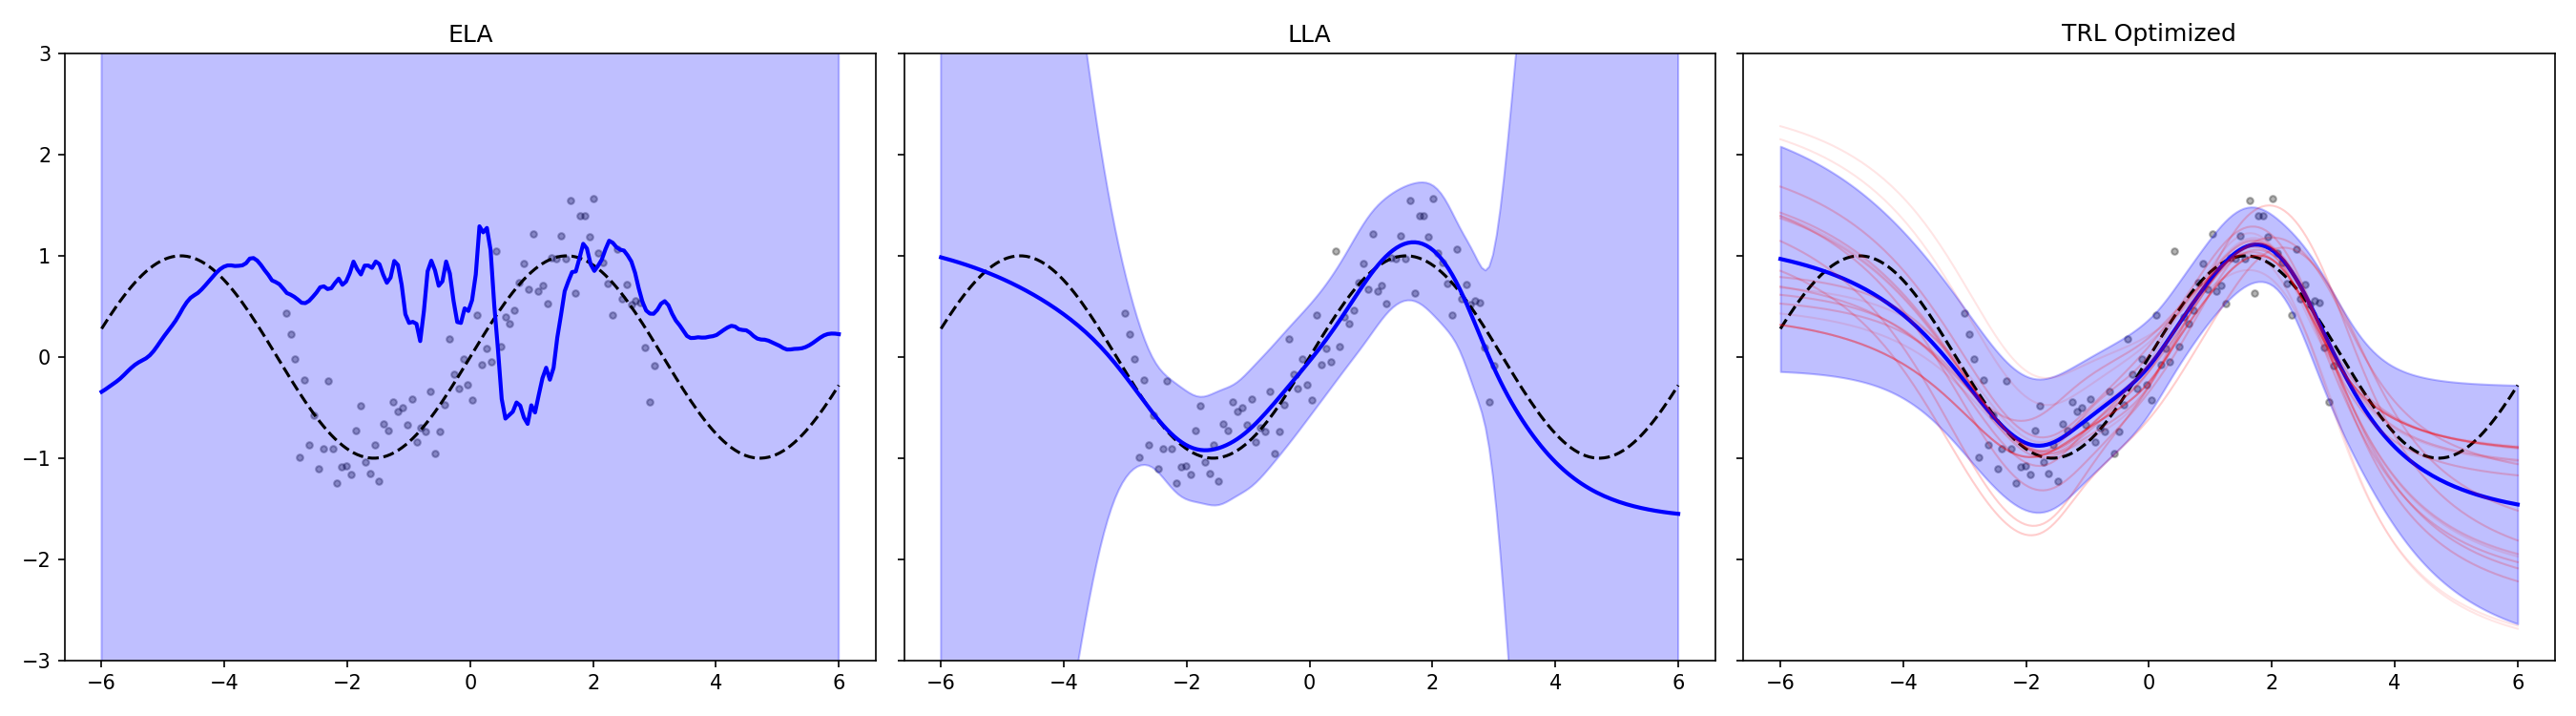

In [ ]:
!python regression_experiment.py
from IPython.display import Image, display
display(Image('sine_regression_ela_lla_trl.png'))

-----

### Célula 6: Executar Two Moons e Ver Imagem

In [ ]:
import torch, math

# carrega as predições salvas pelo script
data = torch.load("sine_predictions.pt")

preds_ela = data["preds_ela"]        # (S, N)
preds_lla = data["preds_lla"]        # (S, N)
preds_trl_full = data["preds_trl_full"]  # (S, N)
y_true = data["y_test"]              # (N,)

metodos = [
    ("ELA", preds_ela),
    ("LLA", preds_lla),
    ("TRL(Hess, perp=0.08)", preds_trl_full),
]

for name, samples in metodos:
    device = samples.device
    y = y_true.to(device)

    mean = samples.mean(0)
    std  = samples.std(0, unbiased=False) + 1e-8
    var  = std ** 2

    rmse = torch.sqrt(torch.mean((mean - y) ** 2)).item()
    nll  = 0.5 * (torch.log(2 * math.pi * var) + (y - mean) ** 2 / var).mean().item()

    z = (y - mean) / std
    z_mean = z.mean().item()
    z_var  = z.var(unbiased=False).item()

    cover_1 = (z.abs() <= 1.0).float().mean().item()
    cover_2 = (z.abs() <= 2.0).float().mean().item()
    cover_3 = (z.abs() <= 3.0).float().mean().item()

    print(f"\n{name}")
    print(f"  RMSE   = {rmse:.4f}")
    print(f"  NLL    = {nll:.4f}")
    print(f"  z-mean = {z_mean:.4f} (ideal ~ 0)")
    print(f"  z-var  = {z_var:.4f} (ideal ~ 1)")
    print(f"  coverage 1σ (|z|<=1)  = {cover_1:.3f}  (ideal ~ 0.683)")
    print(f"  coverage 2σ (|z|<=2)  = {cover_2:.3f}  (ideal ~ 0.955)")
    print(f"  coverage 3σ (|z|<=3)  = {cover_3:.3f}  (ideal ~ 0.997)")

FileNotFoundError: [Errno 2] No such file or directory: 'sine_predictions.pt'

1. Treinando modelo MAP (classificação binária two moons)...
2. Ajustando Laplace (classification, hessian full)...
/usr/local/lib/python3.12/dist-packages/laplace/baselaplace.py:435: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(
3. Grid search de hiperparâmetros do TRL(Hessiana)...

  INICIANDO GRID SEARCH - TRL(Hessiana) CLASSIFICAÇÃO (NLL de validação)
-> Testando 36 combinações de hiperparâmetros...

[01/36] {'step_size': 0.03, 'correction_lr': 0.02, 'perp_scale': 0.05, 'n_steps': 30, 'k_perp': 2000, 'jitter': 0.0001} -> NLL=0.0133 (Brier=0.0014)
    >>> NOVO MELHOR NLL: 0.0133 <<<
[02/36] {'step_size': 0.03, 'correction_lr': 0.02, 'perp_scale': 0.05, 'n_steps': 50, 'k_perp': 2000, 'jitter': 0.0001} -> NLL=0.0128 (Brier=0.0014)
    >>> NOVO MELHOR NLL: 0.0128 <<<
[03/36] {'step_size': 0.03, 'correction_lr': 0.02, 'perp_scale': 0.08, 'n_steps': 30, 'k_perp': 

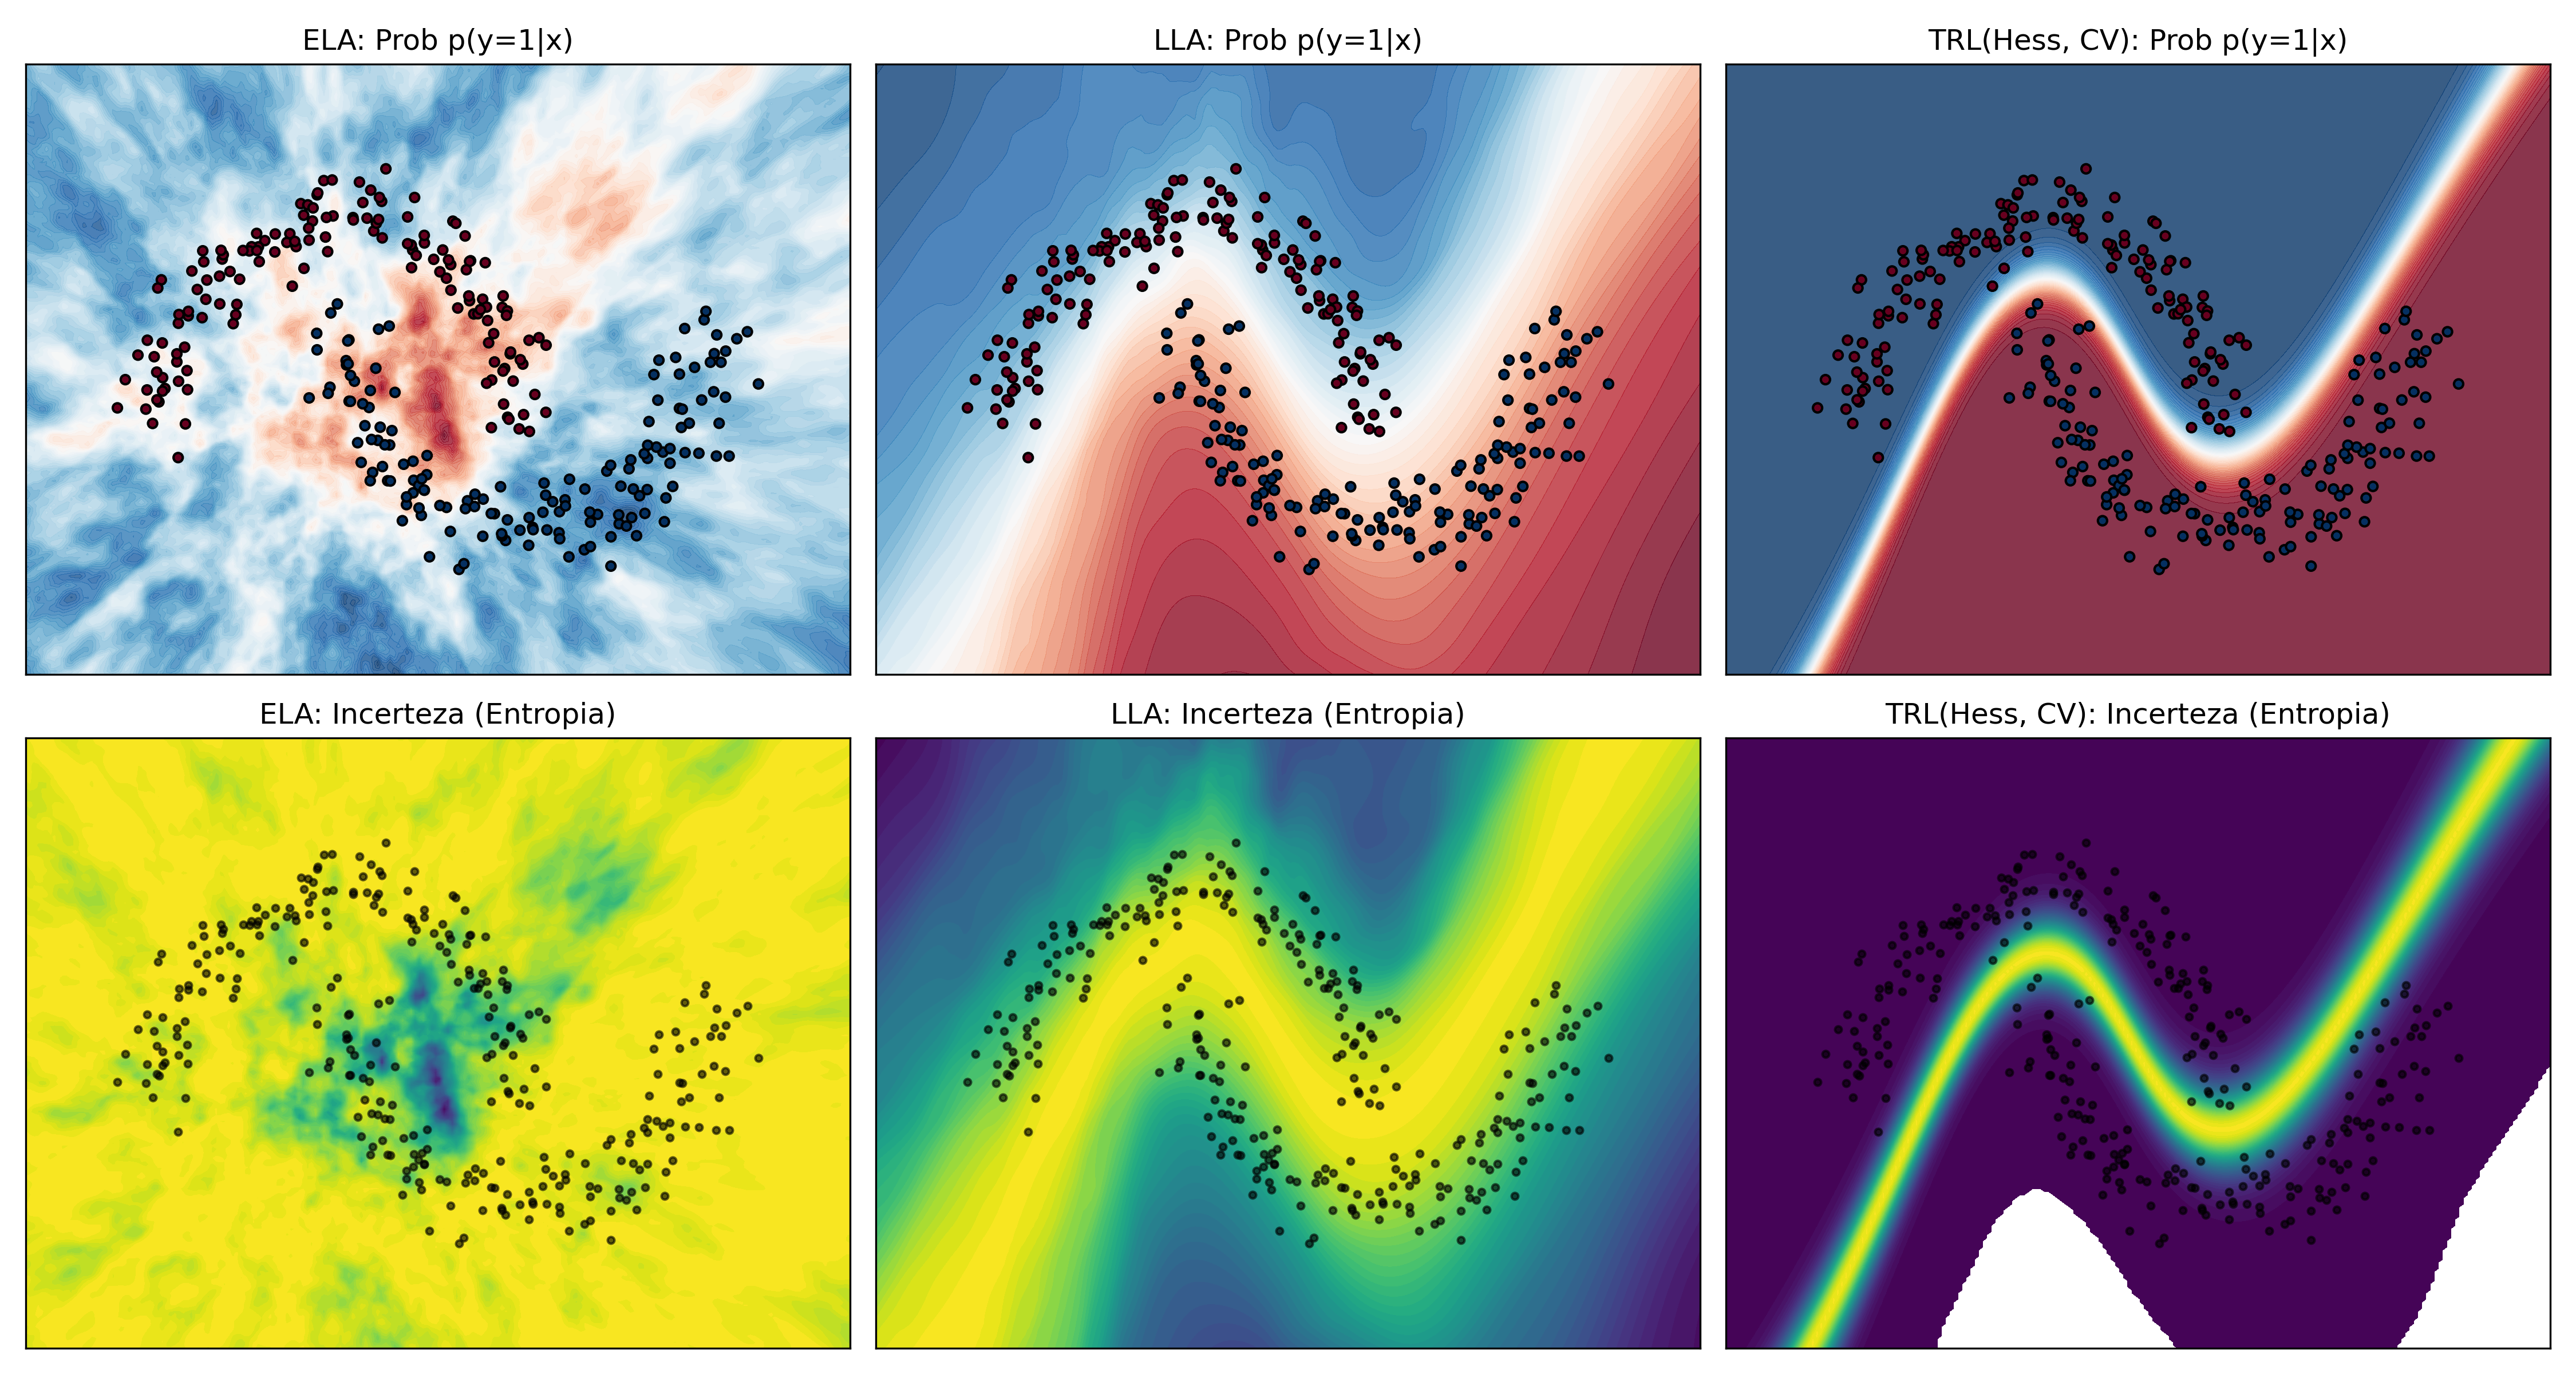

In [ ]:
!python twomoons_experiment.py
from IPython.display import Image, display
display(Image('twomoons_ela_lla_trlcv.png'))

In [ ]:
import torch
import math

# =====================================================
# Carrega as predições salvas pelo twomoons_experiment.py
# =====================================================

data = torch.load("twomoons_predictions.pt")

probs_ela_samples = data["probs_ela_samples"]   # (S, N)
probs_lla_samples = data["probs_lla_samples"]   # (S, N)
probs_trl_samples = data["probs_trl_samples"]   # (S, N)
y_true            = data["y"].float()           # (N,), rótulos 0/1

# =====================================================
# Funções auxiliares (NLL, Brier, entropia, etc.)
# =====================================================

def classification_metrics(probs_mean: torch.Tensor, y_true: torch.Tensor):
    """
    probs_mean: (N,)  prob média p(y=1|x)
    y_true:     (N,)  rótulos 0/1
    """
    y_true = y_true.to(probs_mean.device)
    eps = 1e-8
    p = probs_mean.clamp(min=eps, max=1.0 - eps)

    # NLL Bernoulli
    nll = - (y_true * torch.log(p) + (1.0 - y_true) * torch.log(1.0 - p)).mean().item()

    # Brier score
    brier = ((p - y_true) ** 2).mean().item()

    # acurácia
    y_hat = (p >= 0.5).float()
    acc = (y_hat == y_true).float().mean().item()

    return brier, nll, acc


def binary_entropy(p: torch.Tensor):
    """
    Entropia binária H(p) = - p log p - (1-p) log(1-p)
    (usada como medida de incerteza média)
    """
    eps = 1e-8
    p = p.clamp(min=eps, max=1.0 - eps)
    h = - (p * torch.log(p) + (1.0 - p) * torch.log(1.0 - p))
    return h


# =====================================================
# “Resumo de calibração” para cada método (ELA, LLA, TRL)
# =====================================================

metodos = [
    ("ELA", probs_ela_samples),
    ("LLA", probs_lla_samples),
    ("TRL(Hess, CV)", probs_trl_samples),
]

for name, samples in metodos:
    samples = samples.float()          # (S, N)
    p_mean = samples.mean(dim=0)       # prob média por ponto (N,)
    p_var  = samples.var(dim=0, unbiased=False)  # variância entre amostras (epistêmica)

    brier, nll, acc = classification_metrics(p_mean, y_true)

    # entropia média das predições
    H = binary_entropy(p_mean)
    ent_mean = H.mean().item()

    # “intensidade” média da variância de prob (epistêmica)
    var_mean = p_var.mean().item()

    print(f"\n{name}")
    print(f"  NLL        = {nll:.4f}")
    print(f"  Brier      = {brier:.4f}")
    print(f"  Acurácia   = {acc:.4f}")
    print(f"  Entropia média H(p)      = {ent_mean:.4f}")
    print(f"  Var[p(y=1|x)] média (MC) = {var_mean:.4f}")


ELA
  NLL        = 0.6992
  Brier      = 0.2530
  Acurácia   = 0.5433
  Entropia média H(p)      = 0.6908
  Var[p(y=1|x)] média (MC) = 0.2300

LLA
  NLL        = 0.4123
  Brier      = 0.1162
  Acurácia   = 1.0000
  Entropia média H(p)      = 0.6279
  Var[p(y=1|x)] média (MC) = 0.1976

TRL(Hess, CV)
  NLL        = 0.0712
  Brier      = 0.0104
  Acurácia   = 1.0000
  Entropia média H(p)      = 0.1982
  Var[p(y=1|x)] média (MC) = 0.0311
